In [1]:
import json
import pandas as pd
import sys
sys.path.append('../src/')
import utils.eval.rewards as rw
from utils.data.prompt_utils import qaform
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt
from process_plot import loadf, makengs, plot_methods, intervmean, combineall
import torch

/u/prasanns/miniconda3/envs/fixenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.rl_utils import get_pipeline

/u/prasanns/miniconda3/envs/fixenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:144: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [18]:
roll = pd.read_json("../outputs/results/dynarmlogs/math/log.jsonl", orient='records', lines=True)

In [40]:
roll = pd.read_json("../outputs/results/rollouts/unique_nns/ppo_opormbaseunn.jsonl", orient='records', lines=True)

In [103]:
ssgolds = []
for i, r in roll.iterrows():
    ssgolds.extend(r['golds'])

In [20]:
len(ssgolds)

NameError: name 'ssgolds' is not defined

In [22]:
ptok, rmpipe = get_pipeline("../outputs/models/math/tiny_rm/", device=5)

using pipeline with pad token  </s>
pipeline sanity  [{'label': 'LABEL_0', 'score': 0.5155589580535889}, {'label': 'LABEL_0', 'score': 0.4564097821712494}]


In [49]:
sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 90, "truncation": True}
rmpipe(['yo', 'my', 'bow'], **sent_kwargs)

/u/prasanns/miniconda3/envs/fixenv/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[[{'label': 'LABEL_0', 'score': -4.6875}],
 [{'label': 'LABEL_0', 'score': -2.328125}],
 [{'label': 'LABEL_0', 'score': -4.1875}]]

In [3]:
inps = pd.read_json("accdata/mathwarm.json", orient='records', lines=True)

In [ ]:
inps

In [41]:
# get the stuff
def goldupdate(indf, task, updrm=False, sscos=False, bsize=64):
    sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": bsize, "truncation": True}
    outset, mrws, golds, rwscos, selfscos, staticscos = [], [], [], [], [], []
    buff=0
    for i, row in tqdm(indf.iterrows(), total=len(indf)):
        tmpouts = []
        if 'outputs' in row.keys():
            for j in range(len(row['outputs'])):
                tmpouts.append(qaform(row['inputs'][j],row['outputs'][j].strip()))
        else:
            tmpouts.extend(row['texts'])
        outset.extend(tmpouts)
        mrws.extend(row['rewards'])
        if 'golds' in row.keys():
            golds.extend(row['golds'])
        buff+=len(tmpouts)
        if ((buff==bsize) or (i==len(indf)-1)): 
            if updrm:
                # DO RM eval on questions [we will really want to save this new thing]hu
                with torch.no_grad():
                    staticscos.extend([s[0]['score'] for s in rmpipe(outset[-buff:], **sent_kwargs)])
            if 'golds' not in row.keys():
                golds.extend(rw.get_synth_rewards(outset[-buff:], task))
            buff=0
        if sscos:
            selfscos.extend(row['selfscos'])
    result = {
        'activesco':mrws,
        'gold':golds,
        'outs':outset,
    }
    if updrm:
        result['staticsco'] = staticscos
    if sscos: 
        result['selfsco'] = selfscos
    return result

In [43]:
newres = goldupdate(roll, 'unique_nns', False, False, 8)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.07it/s]


In [120]:
savecdtmp = pd.DataFrame(newres)
savecdtmp.to_json("accdata/eurmsave.json", orient='records', lines=True)

In [28]:
len(newres['gold'])

16512

In [69]:
# saveunntmp = pd.DataFrame(newres)
savecdtmp = pd.DataFrame(newres)

In [70]:
# savecdtmp.to_json("accdata/cdsave.json", orient='records', lines=True)

In [57]:
golds, oldrews, outs, sscs = goldupdate(roll, "math", False, True)
# golds, oldrews, outs, stats = goldupdate(roll, "math", True)

4070it [00:04, 852.02it/s]


In [33]:
tmpdata = pd.DataFrame({'gold':golds, 'activerm':oldrews, 'outputs':outs, 'staticrm':stats})#

In [78]:
tmpdata['selfrew'] = sscs

In [79]:
# tmpdata.to_json("accdata/mathwarm.json", orient='records', lines=True)

In [23]:
oldrews[:8]

[8.0, 9.5, 9.5625, 9.875, 8.625, 9.0, 8.125, 8.3125]

In [28]:
len(stats)
len(oldrews)

64560

In [43]:
golds, oldrews, outs = goldupdate(roll, "math")

1000it [00:01, 929.13it/s]


In [3]:
def accstats(preds, golds, window=100, freq=40):
    assert len(preds)==len(golds)
    # only use a certain number of points
    rat = int(len(golds)/(freq))
    print(rat)
    accs = []
    for i in tqdm(range(0, len(preds)-rat, rat)):
        rights = []
        for j in range(max(0, i-window*2), i+window*2, 2):
            if golds[j+1]==golds[j]:
                continue
            rights.append(1 if (preds[j]>preds[j+1])==(golds[j]>golds[j+1]) else 0)
        accs.append(mean(rights))
    return accs


In [14]:
# print(inps.keys())
print(newres.keys())

dict_keys(['activesco', 'gold', 'outs'])


In [37]:
astats = accstats(newres['activesco'], newres['gold'], 50, 100)
# astats = accstats(list(inps['staticrm']), list(inps['gold']), 100, 40)

160


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 14210.68it/s]


[0.8888888888888888, 0.8777777777777778, 0.9080459770114943, 0.9156626506024096, 0.8863636363636364, 0.7816091954022989, 0.7471264367816092, 0.7349397590361446, 0.618421052631579, 0.5641025641025641, 0.6707317073170732, 0.7297297297297297, 0.5789473684210527, 0.6111111111111112, 0.5769230769230769, 0.6956521739130435, 0.6233766233766234, 0.6794871794871795, 0.5294117647058824, 0.6419753086419753, 0.6463414634146342, 0.6744186046511628, 0.5714285714285714, 0.5652173913043478, 0.6086956521739131, 0.5070422535211268, 0.6417910447761194, 0.589041095890411, 0.5657894736842105, 0.6438356164383562, 0.5942028985507246, 0.6338028169014085, 0.5373134328358209, 0.5757575757575758, 0.5, 0.5373134328358209, 0.5166666666666667, 0.5555555555555556, 0.6027397260273972, 0.6301369863013698, 0.5797101449275363, 0.5151515151515151, 0.5211267605633803, 0.609375, 0.5942028985507246, 0.6052631578947368, 0.5507246376811594, 0.4936708860759494, 0.5657894736842105, 0.5915492957746479, 0.5921052631578947, 0.5753

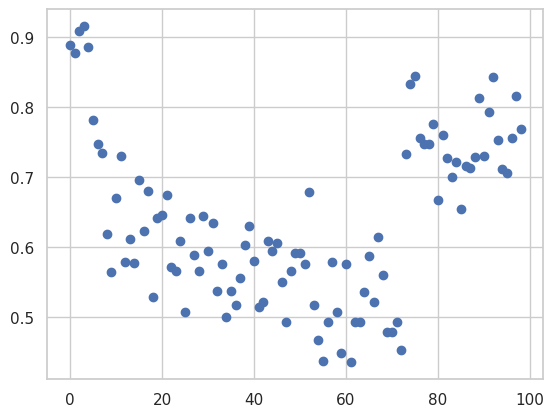

In [38]:
plt.scatter(range(len(astats)), astats)
print(astats)

In [ ]:
plot_methods(mathaccres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Math", fname ='mathd2poaccs.pdf')

In [5]:
# print(astats)
bowaccres = {
    "D2PO RM": (2, [0.7152641878669276, 0.6109785202863962, 0.5669856459330144, 0.6124284546197875, 0.5993322203672788, 0.5980551053484603, 0.6135425268373246, 0.611689351481185, 0.683641975308642, 0.6643137254901961, 0.6854646544876887, 0.7078477078477079, 0.6914556962025317, 0.6972843450479234, 0.6759639048400328, 0.6951915240423798, 0.7287716405605935, 0.7730263157894737, 0.7294727744165946, 0.7547332185886403, 0.7473118279569892, 0.7442650807136788, 0.7726199842643587, 0.7640538400633412, 0.8051323175621492, 0.8008474576271186, 0.8227746591820368, 0.813215859030837, 0.824468085106383, 0.8399646330680813, 0.8250497017892644, 0.8091762252346194, 0.820675105485232, 0.8680851063829788, 0.7969924812030075, 0.8172757475083057, 0.7812828601472135, 0.8341121495327103, 0.8780487804878049]),
    "Static RM": (2, [0.5841487279843445, 0.5640413683373111, 0.6124401913875598, 0.553556827473426, 0.5475792988313857, 0.5470016207455429, 0.5590421139554087, 0.5476381104883907, 0.529320987654321, 0.56, 0.5845909451945989, 0.5757575757575758, 0.564873417721519, 0.5638977635782748, 0.5373256767842494, 0.5501222493887531, 0.5614179719703215, 0.5929276315789473, 0.5773552290406223, 0.5740103270223752, 0.568100358422939, 0.556499575191164, 0.5696302124311565, 0.5851148060174188, 0.6038492381716118, 0.6, 0.5942261427425822, 0.6220264317180617, 0.6108156028368794, 0.5747126436781609, 0.6391650099403579, 0.6600625651720542, 0.5485232067510548, 0.6099290780141844, 0.5639097744360902, 0.6079734219269103, 0.5531019978969506, 0.5397196261682243, 0.5776053215077606]),
    "D2PO (policy reward)": (2, [0.5259454705364995, 0.5140112089671738, 0.47607655502392343, 0.5059194948697711, 0.5089722675367048, 0.5062761506276151, 0.5129032258064516, 0.5180722891566265, 0.5170278637770898, 0.5111111111111111, 0.5171042163882259, 0.5213537469782433, 0.5217748562037798, 0.5242798353909465, 0.5416666666666666, 0.531390134529148, 0.5410700828937453, 0.5329202168861348, 0.5189481825212684, 0.5334890965732088, 0.5136612021857924, 0.5526742301458671, 0.48997594226142743, 0.5620496397117695, 0.5560032232070911, 0.5255889520714866, 0.5656814449917899, 0.5513146734520781, 0.5446205170975813, 0.5253654342218401, 0.528395061728395, 0.5236947791164659, 0.5585725368502715, 0.5399515738498789, 0.5430194805194806, 0.5031897926634769, 0.554177005789909, 0.5444810543657331, 0.543921916592724])
}
mathaccres = {
    "D2PO RM": (1, [0.6342364532019704, 0.5166320166320166, 0.6273381294964029, 0.4666666666666667, 0.570054945054945, 0.48501664816870144, 0.6106194690265486, 0.5583905789990187, 0.550321199143469, 0.5028195488721805, 0.5843137254901961, 0.5206786850477201, 0.5498489425981873, 0.5791324736225087, 0.5377207062600321, 0.5114942528735632, 0.5699088145896657, 0.5302491103202847, 0.5501519756838906, 0.48287292817679556, 0.5943396226415094, 0.4879518072289157, 0.5321375186846039, 0.5435028248587571, 0.5511363636363636, 0.5279685966633955, 0.598937583001328, 0.4619815668202765, 0.5479833101529903, 0.528101802757158, 0.5503875968992248, 0.540650406504065, 0.5876712328767123, 0.4539249146757679, 0.5710227272727273, 0.5260303687635575, 0.5502958579881657, 0.6203143893591294, 0.552833078101072, 0.5334051724137931, 0.5871313672922251, 0.5, 0.5428109854604201, 0.5077105575326216, 0.5606060606060606, 0.6029556650246305, 0.5928753180661578, 0.621875, 0.5787401574803149, 0.5835073068893528]),
    "Static RM": (1, [0.5365853658536586, 0.4959349593495935, 0.45, 0.46296296296296297, 0.40336134453781514, 0.5229357798165137, 0.45161290322580644, 0.536144578313253, 0.5, 0.46846846846846846, 0.5495495495495496, 0.5568181818181818, 0.5154639175257731, 0.494949494949495, 0.4948453608247423, 0.5419847328244275, 0.49074074074074076, 0.5048543689320388, 0.4444444444444444, 0.5350877192982456, 0.5661764705882353, 0.4953271028037383, 0.4818181818181818, 0.546875, 0.5447154471544715, 0.43558282208588955, 0.5213675213675214, 0.472, 0.6464646464646465, 0.5660377358490566, 0.5360824742268041, 0.46551724137931033, 0.5419847328244275, 0.46153846153846156, 0.5851063829787234, 0.43859649122807015, 0.44696969696969696, 0.5547445255474452, 0.5546218487394958]),
    "D2PO (policy reward)": (1, [0.4839901477832512, 0.553014553014553, 0.5179856115107914, 0.5819209039548022, 0.5302197802197802, 0.5882352941176471, 0.5457227138643068, 0.5868498527968596, 0.4668094218415418, 0.5413533834586466, 0.4849673202614379, 0.5535524920466596, 0.49244712990936557, 0.5627198124267292, 0.4767255216693419, 0.5195402298850574, 0.5030395136778115, 0.527876631079478, 0.4756838905775076, 0.5138121546961326, 0.5078616352201258, 0.5433734939759036, 0.5201793721973094, 0.5141242937853108, 0.484375, 0.5309126594700687, 0.50066401062417, 0.5046082949308756, 0.4951321279554937, 0.513255567338282, 0.4974160206718346, 0.5467479674796748, 0.5, 0.47440273037542663, 0.4900568181818182, 0.4631236442516269, 0.48668639053254437, 0.5574365175332527, 0.5160796324655437, 0.5387931034482759, 0.5335120643431636, 0.5767441860465117, 0.5040387722132472, 0.5776986951364176, 0.5075757575757576, 0.547783251231527, 0.4770992366412214, 0.6125, 0.5039370078740157, 0.5532359081419624])
}
nounaccres = {
    "D2PO RM":(0.5, [0.789551140544518, 0.7641242937853108, 0.7277059223961879, 0.7340644276901988, 0.7095871238628412, 0.6903735632183908, 0.66545981173063, 0.6505415162454874, 0.6498559077809798, 0.6652512384996462, 0.6973590292648109, 0.7042857142857143, 0.7189964157706094, 0.7238644556596971, 0.7369942196531792, 0.7561327561327561, 0.7647907647907648, 0.7626628075253257, 0.7578181818181818, 0.7600297176820208, 0.7563338301043219, 0.7629407351837959, 0.7711111111111111, 0.7574654042243263, 0.7665937272064187, 0.7772096420745069, 0.7848194546794399, 0.8149518874907475, 0.8142116950407106, 0.8217168011738811, 0.821349147516679, 0.8220402084884587, 0.8269375470278405, 0.8373168851195065, 0.8361801242236024, 0.8359253499222395, 0.8264591439688715, 0.8191738113795791, 0.8282591725214676]),
    "Static RM": (0.5, [0.6990434142752023, 0.730225988700565, 0.7433628318584071, 0.684715558601782, 0.616515045486354, 0.5926724137931034, 0.5843591600289645, 0.5718411552346571, 0.5965417867435159, 0.5796178343949044, 0.5874375446109922, 0.5764285714285714, 0.5684587813620071, 0.578226387887527, 0.569364161849711, 0.5829725829725829, 0.562049062049062, 0.5564399421128798, 0.5534545454545454, 0.5653789004457652, 0.5566318926974665, 0.5483870967741935, 0.5555555555555556, 0.5418790968681719, 0.5463165572574763, 0.5661066471877283, 0.5571112748710391, 0.5655070318282753, 0.5788304959289415, 0.5634629493763756, 0.5693106004447739, 0.5539836187639613, 0.5402558314522197, 0.5497301464919044, 0.5341614906832298, 0.5342146189735615, 0.5416342412451361, 0.5354637568199533, 0.5386416861826698]), 
    "D2PO (policy reward)": (0.5, [0.5408388520971302, 0.5254237288135594, 0.5098706603131382, 0.5147361206305688, 0.5136459062281316, 0.5158045977011494, 0.5271542360608255, 0.5169675090252708, 0.5129682997118156, 0.5145081387119603, 0.5153461812990721, 0.5285714285714286, 0.5304659498207885, 0.5291997116077866, 0.5310693641618497, 0.5425685425685426, 0.5418470418470418, 0.5434153400868307, 0.5316363636363637, 0.5104011887072808, 0.5089418777943369, 0.5041260315078769, 0.5177777777777778, 0.5345957756737072, 0.5463165572574763, 0.5595325054784515, 0.5585851142225498, 0.5477424130273871, 0.5492227979274611, 0.5546588407923698, 0.558932542624166, 0.5644080416976918, 0.5530474040632054, 0.5389360061680802, 0.5225155279503105, 0.5069984447900466, 0.5027237354085603, 0.514419329696025, 0.5292740046838408])
}
cdaccres = {
    "D2PO RM": (1, [0.5343709468223087, 0.55627425614489, 0.5205211726384364, 0.47464239271781533, 0.4522417153996101, 0.5244937949052907, 0.5359947643979057, 0.5630420280186791, 0.5285947712418301, 0.5359327217125383, 0.5299539170506913, 0.5493197278911565, 0.5292553191489362, 0.5038759689922481, 0.5, 0.5574162679425837, 0.5466321243523317, 0.5275080906148867, 0.5488810365135454, 0.5205684367988033, 0.5350269438029254, 0.5082706766917293, 0.5388162951575711, 0.5251063829787234, 0.5482787573467675, 0.4653579676674365, 0.4790697674418605, 0.5213358070500927, 0.5625, 0.5897435897435898, 0.40625, 0.6388888888888888, 0.5, 0.45161290322580644, 0.6, 0.525, 0.5106382978723404, 0.5714285714285714, 0.58]),
    "Static RM": (1,[0.4293125810635538, 0.4126778783958603, 0.4775244299674267, 0.44018205461638493, 0.4048083170890188, 0.45787067276290006, 0.5333769633507853, 0.5023348899266178, 0.5081699346405228, 0.46712538226299694, 0.4700460829493088, 0.4931972789115646, 0.5053191489361702, 0.49767441860465117, 0.5733532934131736, 0.527511961722488, 0.5518134715025906, 0.5361380798274002, 0.5076560659599529, 0.5445026178010471, 0.5265588914549654, 0.5082706766917293, 0.5395849346656418, 0.5157446808510638, 0.5138539042821159, 0.5103926096997691, 0.5023255813953489, 0.5176252319109462, 0.40625, 0.6410256410256411, 0.5625, 0.5833333333333334, 0.6842105263157895, 0.7096774193548387, 0.65, 0.75, 0.6170212765957447, 0.6530612244897959, 0.56]),
    "D2PO (policy reward)": (1, [0.4889753566796368, 0.5084087968952135, 0.5087947882736157, 0.4694408322496749, 0.4158544509421702, 0.4761593729588504, 0.5451570680628273, 0.5156771180787192, 0.548202614379085, 0.5267584097859327, 0.5576036866359447, 0.5773809523809523, 0.5678191489361702, 0.5751937984496124, 0.5479041916167665, 0.5382775119617225, 0.5453367875647669, 0.540453074433657, 0.5206124852767963, 0.46222887060583395, 0.5381062355658198, 0.5518796992481203, 0.5603382013835511, 0.534468085106383, 0.5113350125944585, 0.5115473441108545, 0.4418604651162791, 0.4397031539888683, 0.59375, 0.38461538461538464, 0.40625, 0.5555555555555556, 0.5, 0.45161290322580644, 0.45, 0.55, 0.3829787234042553, 0.5102040816326531, 0.56])
}

eurres = {
    "D2PO RM": (1.5, [0.6130653266331658, 0.58, 0.635, 0.5678391959798995, 0.592964824120603, 0.6683417085427136, 0.645, 0.6, 0.655, 0.67, 0.6414141414141414, 0.5606060606060606, 0.6313131313131313, 0.605, 0.53, 0.565, 0.595, 0.6598984771573604, 0.5829145728643216, 0.5707070707070707, 0.5778894472361809, 0.6331658291457286, 0.5707070707070707, 0.6565656565656566, 0.678391959798995, 0.555, 0.5376884422110553, 0.5879396984924623, 0.59, 0.525, 0.57, 0.545, 0.555, 0.45918367346938777, 0.5707070707070707, 0.6040609137055838, 0.64, 0.585, 0.5829145728643216]),
    "Static RM": (1.5, [0.5628140703517588, 0.555, 0.57, 0.5879396984924623, 0.5276381909547738, 0.5477386934673367, 0.625, 0.62, 0.6, 0.605, 0.6060606060606061, 0.601010101010101, 0.6111111111111112, 0.615, 0.6, 0.605, 0.605, 0.6751269035532995, 0.6130653266331658, 0.6414141414141414, 0.542713567839196, 0.6231155778894473, 0.5656565656565656, 0.5303030303030303, 0.6180904522613065, 0.68, 0.6432160804020101, 0.6381909547738693, 0.6, 0.56, 0.565, 0.565, 0.555, 0.5459183673469388, 0.5606060606060606, 0.6395939086294417, 0.665, 0.595, 0.6231155778894473])
}

<Figure size 1000x600 with 0 Axes>

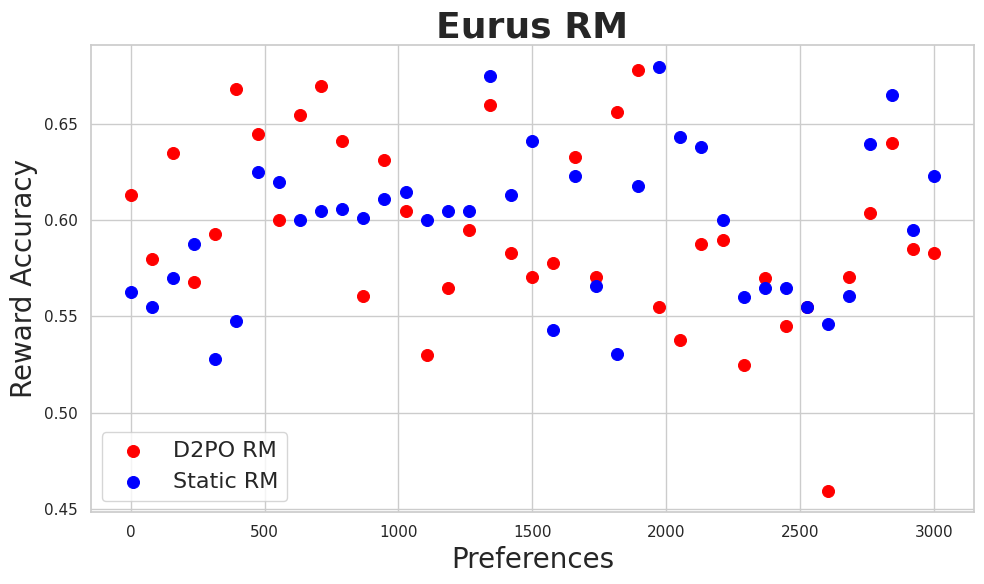

In [20]:
plot_methods(eurres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Eurus RM", fname ='eurd2poaccs.pdf')

<Figure size 1000x600 with 0 Axes>

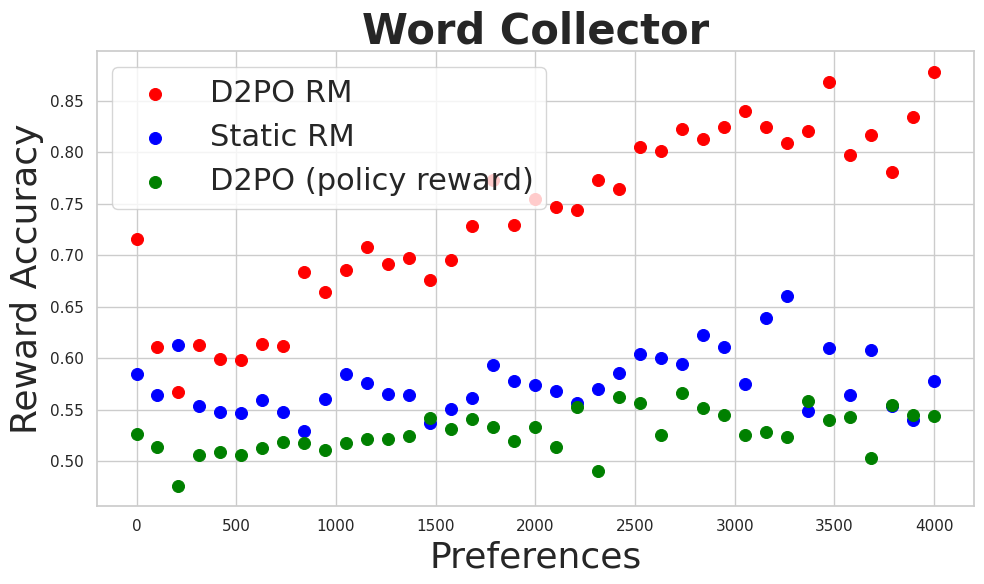

In [4]:
plot_methods(bowaccres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Word Collector", fname ='bowd2poaccs.pdf')

<Figure size 1000x600 with 0 Axes>

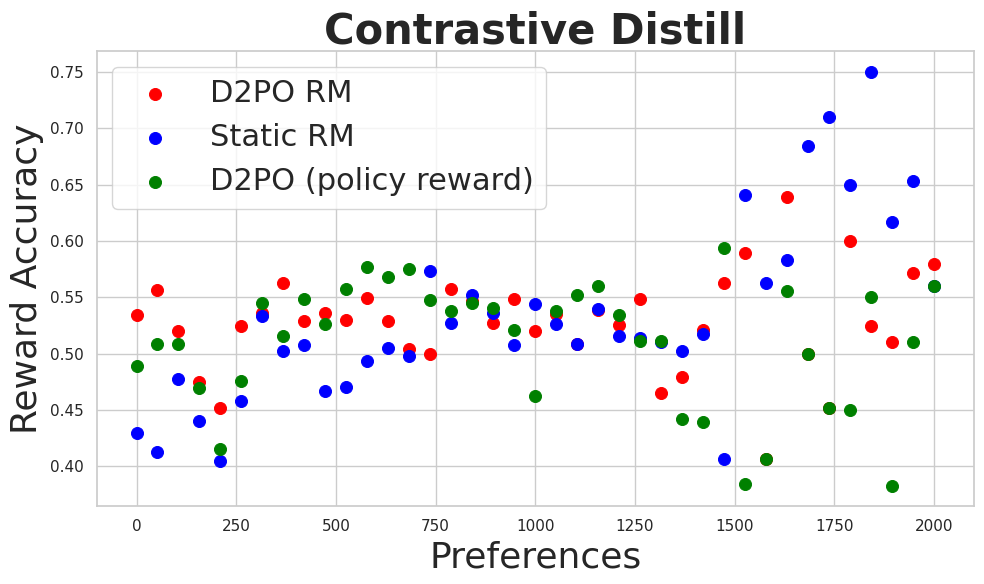

In [5]:
plot_methods(cdaccres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Contrastive Distill", fname ='cdistd2poaccs.pdf')

<Figure size 1000x600 with 0 Axes>

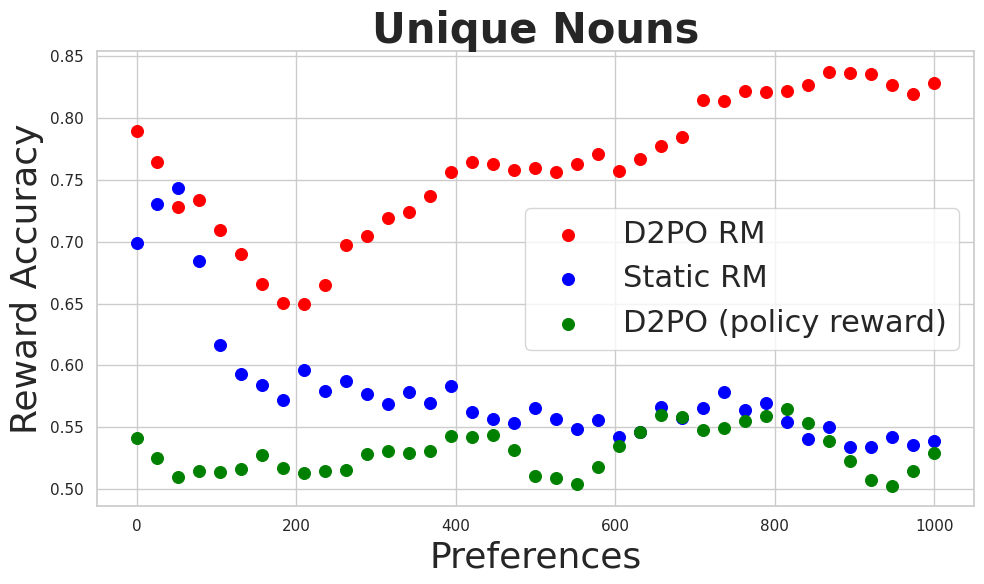

In [6]:
plot_methods(nounaccres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Unique Nouns", fname ='nound2poaccs.pdf')

<Figure size 1000x600 with 0 Axes>

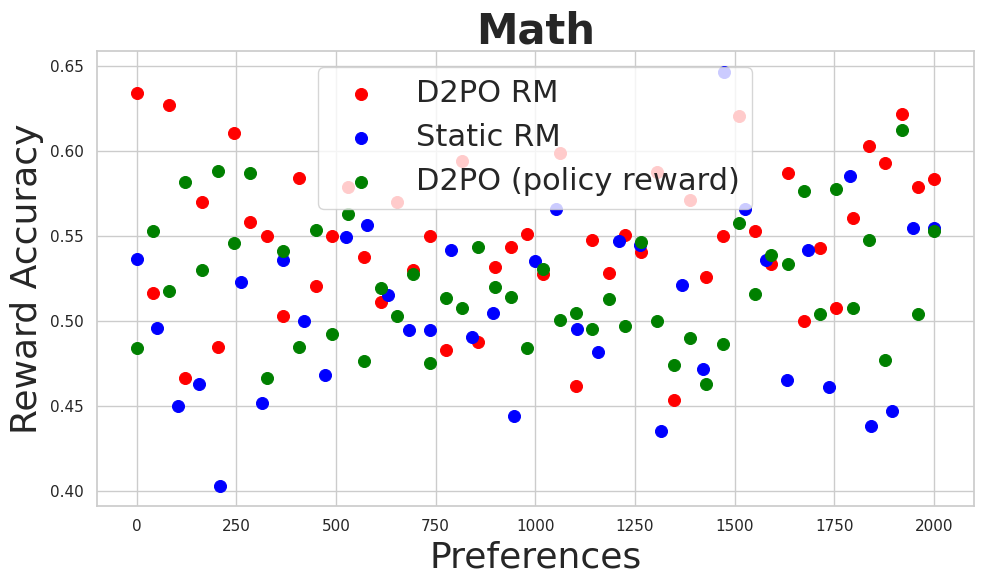

In [7]:
plot_methods(mathaccres, xlabel="Preferences", ylabel="Reward Accuracy", setname="Math", fname ='mathd2poaccs.pdf')

<Figure size 1000x600 with 0 Axes>

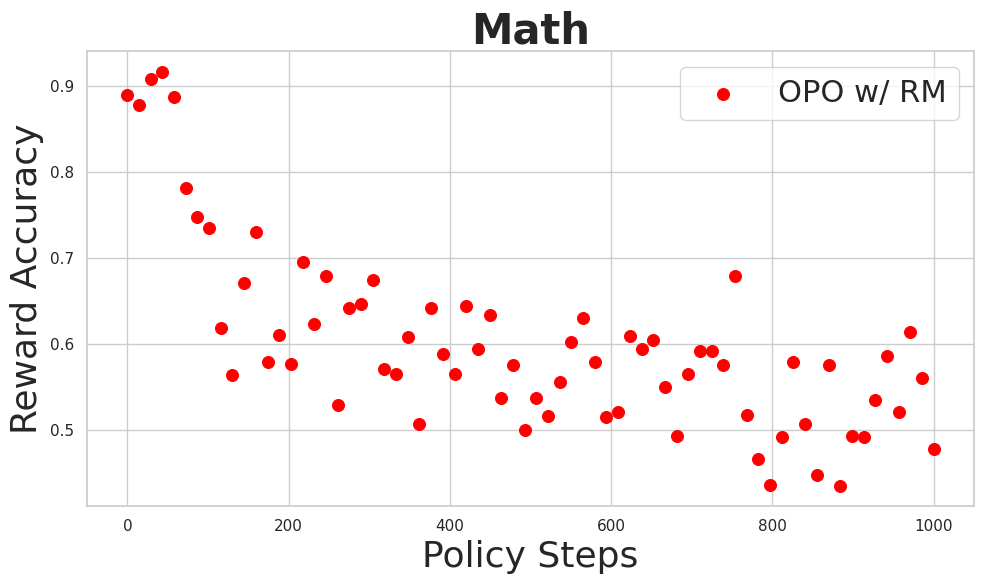

In [39]:
plot_methods({"OPO w/ RM": (0.5, astats[:70])}, xlabel="Policy Steps", ylabel="Reward Accuracy", setname="Math", fname ='mathoffacc.pdf')

In [30]:
s2 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed3.jsonl", orient='records', lines=True)
s3 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefixseed2.jsonl", orient='records', lines=True)
s4 = pd.read_json("../outputs/results/dynarmlogs/contrastivedistill/tiny_rm_rand_cdist_10_5_activefix.jsonl", orient='records', lines=True)

In [64]:
gup = goldupdate(s2, "")
gup3 = goldupdate(s3, "")
gup4 = goldupdate(s4, "")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64000/64000 [00:02<00:00, 27280.30it/s]


In [77]:
def gstats(golds, window=200, freq=20):
    # only use a certain number of points
    rat = int(len(golds)/(freq))
    print(rat)
    accs = []
    for i in tqdm(range(0, len(golds)-rat, rat)):
        # print(i)
        sub = golds[max(0, i-window*2):i+window*2]
        # print(sub)
        accs.append(mean(sub))
    return accs

In [89]:
newgs = gstats(gup3['gold'])

6400


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 3904.16it/s]


In [87]:
s1 = [-0.15302734375000002, -0.1044921875, -0.050273437500000004, 0.028984375, 0.013984375000000002, 0.054843750000000004, 0.033007812500000004, 0.0280078125, 0.0552734375, 0.098984375, 0.1400390625, 0.32109375, 0.314921875, 0.077890625, 0.078125, 0.07542968750000001, 0.08136718750000001, 0.0945703125, 0.1282421875, -0.02703125, -0.012431640625, -0.023027343750000002, -0.009257812499999999, 0.026757812500000002, 0.025, 0.07941406250000001, 0.022734375, 0.0332421875, 0.030820312500000002, 0.0614453125, 0.08429687500000001, 0.109296875, 0.04375, 0.044453125, 0.018632812500000002, 0.0951171875, 0.0801171875, 0.1102734375, 0.22265625]
s2 = [-0.15302734375000002, -0.1044921875, -0.050273437500000004, 0.028984375, 0.013984375000000002, 0.054843750000000004, 0.033007812500000004, 0.0280078125, 0.0552734375, 0.098984375, 0.1400390625, 0.32109375, 0.314921875, 0.077890625, 0.078125, 0.07542968750000001, 0.08136718750000001, 0.0945703125, 0.1282421875, -0.02703125, -0.012431640625, -0.023027343750000002, -0.009257812499999999, 0.026757812500000002, 0.025, 0.07941406250000001, 0.022734375, 0.0332421875, 0.030820312500000002, 0.0614453125, 0.08429687500000001, 0.109296875, 0.04375, 0.044453125, 0.018632812500000002, 0.0951171875, 0.0801171875, 0.1102734375, 0.22265625]


In [133]:
cdistmainres = {
    "S1":(1, [-0.18, -0.18894531250000002, -0.057294921875, 0.024052734375, 0.037402343750000004, 0.03515625, 0.1182421875, 0.1659765625, 0.336953125, 0.15525390625000002, 0.1952978515625, 0.236611328125, 0.2343798828125, 0.2447216796875, 0.242392578125, 0.242392578125, 0.241884765625, 0.25685546875, 0.248037109375, 0.2474560546875, 0.2453125]),
    "S2":(1, [-0.18, 0.13328125000000002, 0.14632486979166667, 0.23262044270833332, 0.19404296875, 0.3395182291666667, 0.4758333333333334, 0.49255208333333333, 0.49869140624999998, 0.43113932291666667, 0.4507633463541666, 0.47795572916666667, 0.5045198567708334, 0.49173665364583334, 0.4806575520833333, 0.49406575520833333, 0.4945735677083334, 0.47830078125, 0.47816731770833336, 0.4619514973958334, 0.4834635416666667]),
    "S3":(1, [-0.18000000000000005, -0.02783203125, 0.04451497395833333, 0.12833658854166669, 0.11572265625, 0.18733723958333331, 0.29703776041666663, 0.32926432291666663, -0.032177734375000044, -0.006803385416666696, 0.1730305989583334, 0.057283528645833304, 0.06944986979166656, 0.06822916666666667, 0.093736979166673, 0.06822916666666667, 0.06822916666666656, 0.06757812500000004, 0.06310221354166656, 0.5047037760416666, 1.2643880208333333]),
    #'D2PO':(1, [-0.18, -0.02783203125, 0.044514973958333336, 0.12833658854166666, 0.11572265625, 0.18733723958333334, 0.2970377604166667, 0.3292643229166667, 0.267822265625, 0.19319661458333334, 0.2730305989583333, 0.2572835286458333, 0.2694498697916667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.2682291666666667, 0.267578125, 0.2631022135416667, 0.4047037760416667, 0.6643880208333334]), 
    'OPO w/ gold':(1,[-0.18, -0.019612630208333332, 0.021769205729166668, 0.06892903645833333, 0.12711588541666666, 0.158935546875, 0.19108072916666666, 0.255126953125, 0.33154296875, 0.2845865885416667, 0.3129069010416667])
}

In [117]:
len(cdistmainres['S1'][1])

20

<Figure size 1000x600 with 0 Axes>

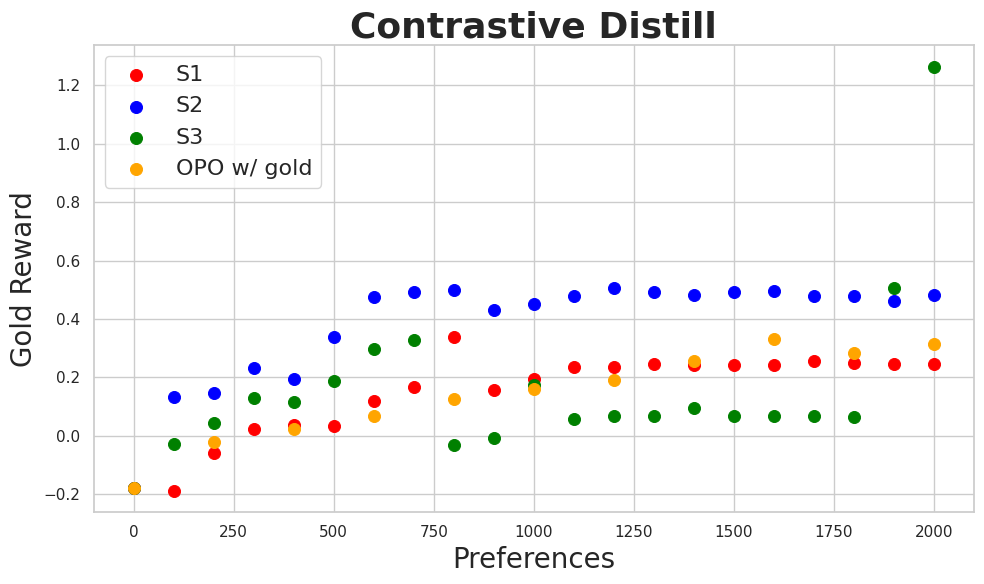

In [134]:
plot_methods(cdistmainres, xlabel="Preferences", ylabel="Gold Reward", setname="Contrastive Distill", fname ='cdtest.pdf')

In [125]:
news = []

In [127]:
print(news)


[-0.18000000000000005, -0.02783203125, 0.04451497395833333, 0.12833658854166669, 0.11572265625, 0.18733723958333331, 0.29703776041666663, 0.32926432291666663, -0.032177734375000044, -0.006803385416666696, 0.1730305989583334, 0.057283528645833304, 0.06944986979166656, 0.06822916666666667, 0.12163736979166673, 0.06822916666666667, 0.06822916666666656, 0.06757812500000004, 0.06310221354166656, 0.5047037760416666, 1.2643880208333333]


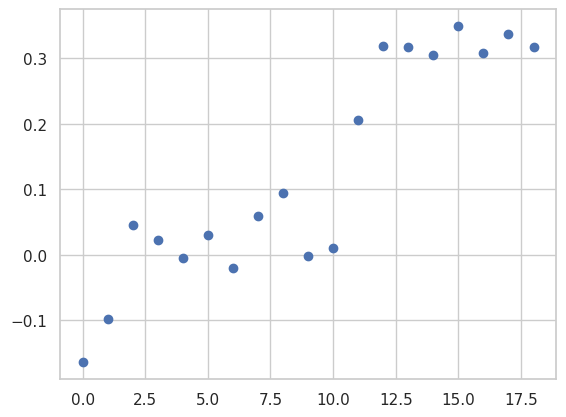

In [90]:
plt.scatter(list(range(len(newgs))), newgs)

In [46]:
len(gup['gold'])

128000

In [56]:
gup['gold'][-100:100]

[]